# Flippy Illusions

Hi! Welcome to the official colab demo for our demo "Diffusion Illusions: Hiding Images in Plain Sight". [https://ryanndagreat.github.io/Diffusion-Illusions/](https://ryanndagreat.github.io/Diffusion-Illusions/)

This project was inspired by our paper "Peekaboo: Text to Image Diffusion Models are Zero-Shot Segmentors". The Peekaboo project website: [https://ryanndagreat.github.io/peekaboo/](https://ryanndagreat.github.io/peekaboo/)

Instructions:

0. Go to the Runtime menu, and make sure this notebook is using GPU!
1. Run the top 2 code cells (one cleans colab's junk and downloads the source code, while the other installs python packages)
2. Click 'Runtime', then 'Restart Runtime'. You need to do this the first time you open this notebook to avoid weird random errors from the pip installations.
3. Run code cells to load stable diffusion. The first time you run it it will take a few minutes to download; subsequent times won't take long at all though.
4. Run all the cells below that, and customize prompt_a and prompt_b!
5. Take the result top_image and bottom_image, print them out, and shine a backlight through them like shown in the Diffusion Illusion website (link above!)

I may also create a YouTube tutorial if there's interest. Let me know if this would be helpful!

This notebook was written by Ryan Burgert. Feel free to reach out to me at rburgert@cs.stonybrook.edu if you have any questions! 

In [1]:
'''%%bash
if [ ! -d ".git" ]; then 
    rm -rf * .*; #Get rid of Colab's default junk files
    git clone -b master https://github.com/RyannDaGreat/Diffusion-Illusions .
fi'''

'%%bash\nif [ ! -d ".git" ]; then \n    rm -rf * .*; #Get rid of Colab\'s default junk files\n    git clone -b master https://github.com/RyannDaGreat/Diffusion-Illusions .\nfi'

In [10]:
#%pip install --upgrade -r requirements.txt
#%pip install rp --upgrade
#%pip install transformers diffusers rich --upgrade
#%pip install easydict --upgrade
#%pip install einops --upgrade 
# You may need to restart the runtime after installing these
# I'm not sure why this helps, but all sorts of weird random errors pop up in Colab if you don't

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import rp
import torch
import torch.nn as nn
import source.stable_diffusion as sd
from easydict import EasyDict
from source.learnable_textures import LearnableImageFourier
from source.stable_diffusion_labels import NegativeLabel
from itertools import chain
import time

In [2]:
#ONLY GOOD PROMPTS HERE
example_prompts = rp.load_yaml_file('source/example_prompts.yaml')
print('Available example prompts:', ', '.join(example_prompts))

#These prompts are all strings - you can replace them with whatever you want! By default it lets you choose from example prompts
#Here are some on the site! It does take some thought to come up with good ideas; the upside-down should look vaguely like the right-side up to work nicely
prompt_a, prompt_b = rp.gather(example_prompts, 'sailing_ship bioshock_lighthouse'.split())
#prompt_a, prompt_b = rp.gather(example_prompts, 'pencil_giraffe_head pencil_penguin'.split())
# prompt_a, prompt_b = rp.gather(example_prompts, 'sailing_ship sailing_ship'.split())

negative_prompt = ''

print()
print('Negative prompt:',repr(negative_prompt))
print()
print('Chosen prompts:')
print('    prompt_a =', repr(prompt_a)) #This will be right-side up
print('    prompt_b =', repr(prompt_b)) #This will be upside-down

Available example prompts: kitten_in_box, botw_landscape, magic_emma_watson, yorkshire_terrier_santa, norwegian_winter_girl, magic_forest_temple, sailing_ship, bioshock_lighthouse, two_bunnys_hugging, thomas_tank_military, wolf_on_rock, victorial_dress, lolita_dress_magical_elf, pencil_giraffe_head, pencil_penguin, pencil_violin, pencil_orca_whale, pencil_cow, pencil_walrus, pencil_cat_head, pencil_dog_head, ape_with_gun, human_skeleton, gold_coins, golf_ball_in_forest, bear_in_forest, elephant_in_circus, mickey_mouse, mushroom, mario, burger, darth_vader, gandalf, fantasy_city, green_elf_girl, pikachu, spring, fall, winter, summer, miku, pyramids, dinosaur, lipstick, picard, bull_wing, froggo, assasin_creed, moon, minecraft_zombie, pistol, disco_ball, volcano, porche, hawaii_beach, walter_white, dalek, tardis, tennant, weeping_angel, giant_tree, massive_chandelier

Negative prompt: ''

Chosen prompts:
    prompt_a = 'a big sailing ship in heavy sea, hypermaximalistic, high details, ci

# New Section

In [3]:
if 's' not in dir():
    model_name="CompVis/stable-diffusion-v1-4"
    gpu='cuda:0'
    s=sd.StableDiffusion(gpu,model_name)
device=s.device

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


[INFO] sd.py: loading stable diffusion...please make sure you have run `huggingface-cli login`.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

[INFO] sd.py: loaded stable diffusion!


In [4]:
label_a = NegativeLabel(prompt_a,negative_prompt)
label_b = NegativeLabel(prompt_b,negative_prompt)

In [5]:
#Image Parametrization and Initialization (this section takes vram)

#Select Learnable Image Size (this has big VRAM implications!):
#Note: We use implicit neural representations for better image quality
#They're previously used in our paper "TRITON: Neural Neural Textures make Sim2Real Consistent" (see tritonpaper.github.io)
# ... and that representation is based on Fourier Feature Networks (see bmild.github.io/fourfeat)
learnable_image_maker = lambda: LearnableImageFourier(height=256, width=256, hidden_dim=256, num_features=128).to(s.device); SIZE=256
# learnable_image_maker = lambda: LearnableImageFourier(height=512,width=512,num_features=256,hidden_dim=256,scale=20).to(s.device);SIZE=512

image=learnable_image_maker()

In [6]:
learnable_image_a=lambda: image() #Right-side up
learnable_image_b=lambda: image().rot90(k=2,dims=[1,2]) #Upside-down

optim=torch.optim.SGD(image.parameters(),lr=1e-4)

In [7]:
labels=[label_a,label_b]
learnable_images=[learnable_image_a,learnable_image_b]

#The weight coefficients for each prompt. For example, if we have [0,1], then only the upside-down mode will be optimized
weights=[1,1]

weights=rp.as_numpy_array(weights)
weights=weights/weights.sum()
weights=weights*len(weights)

In [8]:
#For saving a timelapse
ims=[]

In [9]:
def get_display_image():
    return rp.tiled_images(
        [
            rp.as_numpy_image(learnable_image_a()),
            rp.as_numpy_image(learnable_image_b()),
        ],
        length=len(learnable_images),
        border_thickness=0,
    )

Every 200 iterations we display an image in the form [image_a, image_b], where
    image_a = (the right-side up image)
    image_b = (image_a, but upside down)

Interrupt the kernel at any time to return the currently displayed image
You can run this cell again to resume training later on

Please expect this to take quite a while to get good images (especially on the slower Colab GPU's)! The longer you wait the better they'll be


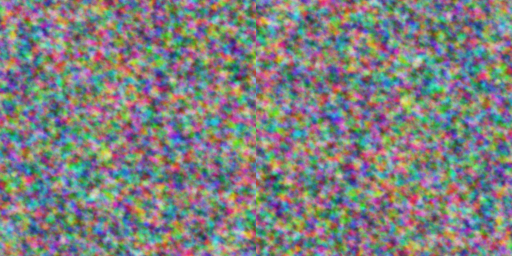

Status: ETR=0:49:53.546518	ETA=0:50:54.639304	T=0:01:01.092786	Progress: 200/10000

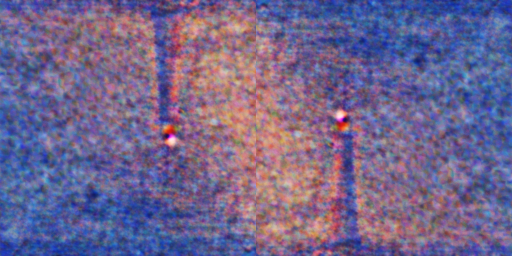

Status: ETR=0:48:46.585876	ETA=0:50:48.526955	T=0:02:01.941078	Progress: 400/10000

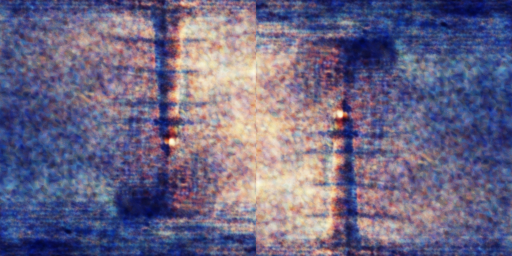

Status: ETR=0:48:31.065357	ETA=0:50:49.513259	T=0:02:18.447902	Progress: 454/10000

In [ ]:
NUM_ITER=10000

#Set the minimum and maximum noise timesteps for the dream loss (aka score distillation loss)
s.max_step=MAX_STEP=990
s.min_step=MIN_STEP=10 

display_eta=rp.eta(NUM_ITER, title='Status')

DISPLAY_INTERVAL = 200

print('Every %i iterations we display an image in the form [image_a, image_b], where'%DISPLAY_INTERVAL)
print('    image_a = (the right-side up image)')
print('    image_b = (image_a, but upside down)')
print()
print('Interrupt the kernel at any time to return the currently displayed image')
print('You can run this cell again to resume training later on')
print()
print('Please expect this to take quite a while to get good images (especially on the slower Colab GPU\'s)! The longer you wait the better they\'ll be')

try:
    for iter_num in range(NUM_ITER):
        display_eta(iter_num) #Print the remaining time

        preds=[]
        for label,learnable_image,weight in rp.random_batch(list(zip(labels,learnable_images,weights)), batch_size=1):
            pred=s.train_step(
                label.embedding,
                learnable_image()[None],

                #PRESETS (uncomment one):
                noise_coef=.1*weight,guidance_scale=60,#10
                # noise_coef=0,image_coef=-.01,guidance_scale=50,
                # noise_coef=0,image_coef=-.005,guidance_scale=50,
                # noise_coef=.1,image_coef=-.010,guidance_scale=50,
                # noise_coef=.1,image_coef=-.005,guidance_scale=50,
                # noise_coef=.1*weight, image_coef=-.005*weight, guidance_scale=50,
            )
            preds+=list(pred)

        with torch.no_grad():
            if iter_num and not iter_num%(DISPLAY_INTERVAL*50):
                #Wipe the slate every 50 displays so they don't get cut off
                from IPython.display import clear_output
                clear_output()

            if not iter_num%DISPLAY_INTERVAL:
                im = get_display_image()
                ims.append(im)
                rp.display_image(im)

        optim.step()
        optim.zero_grad()
except KeyboardInterrupt:
    print()
    print('Interrupted early at iteration %i'%iter_num)
    im = get_display_image()
    ims.append(im)
    rp.display_image(im)

Right-side up image:


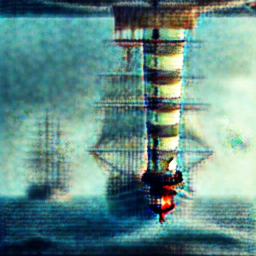

Upside-down image:


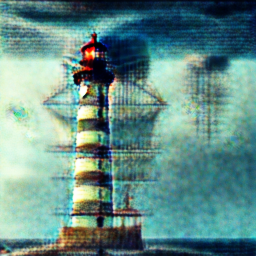

In [11]:
print('Right-side up image:')
rp.display_image(rp.as_numpy_image(learnable_image_a()))

print('Upside-down image:')
rp.display_image(rp.as_numpy_image(learnable_image_b()))

In [12]:
import hashlib

def save_run(name):
    # 폴더 이름이 너무 길 경우 해시를 사용해 축약
    if len(name) > 200:  # 길이에 대한 안전 여유
        name_hash = hashlib.sha256(name.encode()).hexdigest()[:10]  # 해시값을 짧게 사용
        name = f"{name[:50]}_{name_hash}"
    
    folder = "untracked/flippy_illusion_runs_ship/%s" % name
    if rp.path_exists(folder):
        folder += '_%i' % time.time()
    rp.make_directory(folder)
    ims_names = ['ims_%04i.png' % i for i in range(len(ims))]
    with rp.SetCurrentDirectoryTemporarily(folder):
        rp.save_images(ims, ims_names, show_progress=True)
    print()
    print('Saved timelapse to folder:', repr(folder))

# 축약된 이름 생성
name = '-'.join([prompt_a, prompt_b])
save_run(name)


Saving Images: ETR=0:00:00.390179	ETA=0:00:00.750344	T=0:00:00.360165	Progress: 24/50rp.save_images: Done! Saved 50 images in 0.604 seconds

Saved timelapse to folder: 'untracked/flippy_illusion_runs_ship/a big sailing ship in heavy sea, hypermaximalistic_9ef9b684a7'
